In [54]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [55]:
import pickle 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra

from pprint import pp
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import ConstantBounds
from utils.cobra_utils import get_or_create_exchange
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes


MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set maintenance to 25 mmol/gDW/h
atpm = model.reactions.get_by_id("ATPM")
# atpm.bounds = (25, 25)

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

In [56]:
df = pd.read_excel("../data/raw/growth/essentiality - July 2023.xlsx")
df = df[~df["Mutant (yes/no)"].isna()]
df["Essential"] = (df["Mutant (yes/no)"] == "no")

In [57]:
# Get fluxes when running on glucose, acetate
with model:
    ex_glc.bounds = (-10, 0)
    sol_glc = model.optimize()
    mu_glc = sol_glc.objective_value
    model.summary()
    print(f"Glucose growth: {sol_glc.objective_value:.2f}")

Glucose growth: 1.13


In [58]:
# We need to create a mapping from model genes to (index of) data genes
model_to_data_genes = {}

# Most genes in the model are ID'd by their RefSeq locus tag:
print(f"Model has {len(model.genes)} genes")

matched_by_rs_locus_tag = {}
for gene in model.genes:
    if "_RS" not in gene.id:
        continue

    match = (df[df["RefSeq_locus_tag"] == gene.id]
                if gene.id in df["RefSeq_locus_tag"].values
                else None)
    if match is not None:
        assert len(match) == 1
        matched_by_rs_locus_tag[gene] = match.index[0]

model_to_data_genes.update(matched_by_rs_locus_tag)
print(f"Model has {len([gene for gene in model.genes if "_RS" in gene.id])} genes ID'd by RefSeq locus tags")
print(f"{len(matched_by_rs_locus_tag)} genes in the model can be matched to essentiality data by RefSeq locus tag")

Model has 904 genes
Model has 174 genes ID'd by RefSeq locus tags
173 genes in the model can be matched to essentiality data by RefSeq locus tag


In [59]:
# Try locus tag for the remaining genes
remaining_genes = {gene for gene in model.genes if gene not in model_to_data_genes}

matched_by_locus_tag = {}
for gene in remaining_genes:
    if gene.id in df["locus_tag"].values:
        match = df[df["locus_tag"] == gene.id].index[0]
        matched_by_locus_tag[gene] = match

model_to_data_genes.update(matched_by_locus_tag)
print(f"Of the {len(remaining_genes)} remaining genes not ID'd by RefSeq locus tag, {len(matched_by_locus_tag)} can be matched by locus tag")

Of the 731 remaining genes not ID'd by RefSeq locus tag, 499 can be matched by locus tag


In [60]:
remaining_genes = {gene for gene in model.genes if gene not in model_to_data_genes}
lefts = [float(gene.annotation["left-end-position"]) for gene in remaining_genes]
rights = [float(gene.annotation["right-end-position"]) for gene in remaining_genes]

# Try to match by position for the remaining genes
matched_by_position = {}
for gene, left, right in zip(remaining_genes, lefts, rights):
    matches = df[((df["start"] == left) & (df["stop"] == right)) 
                 | (df["start"] == right) & (df["stop"] == left)]
    if len(matches) == 1:
        print(f"{gene} matched by position to {matches['locus_tag'].values[0]}")
        matched_by_position[gene] = matches.index[0]

model_to_data_genes.update(matched_by_position)

print(f"{len(matched_by_position)} out of {len(remaining_genes)} genes matched by position,")
print(f"\tleaving {len(remaining_genes) - len(matched_by_position)} genes unmatched.")

G1RHL-2589 matched by position to SPO3408
G1RHL-1255 matched by position to SPO1674
G1RHL-2418 matched by position to SPO3176
G1RHL-2865 matched by position to SPO3771
G1RHL-1180 matched by position to SPO1581
G1RHL-2109 matched by position to SPO2762
G1RHL-1712 matched by position to SPO2272
G1RHL-688 matched by position to SPO0977
G1RHL-791 matched by position to SPO1105
G1RHL-2467 matched by position to SPO3252
G1RHL-992 matched by position to SPO1362
G1RHL-1661 matched by position to SPO2211
G1RHL-516 matched by position to SPO0751
G1RHL-2919 matched by position to SPO3851
G1RHL-2313 matched by position to SPO3035
G1RHL-1887 matched by position to SPO2505
G1RHL-318 matched by position to SPO0466
G1RHL-2767 matched by position to SPO3650
G1RHL-3 matched by position to SPO0007
G1RHL-1303 matched by position to SPO1743
G1RHL-2048 matched by position to SPO2697
G1RHL-2461 matched by position to SPO3244
G1RHL-1167 matched by position to SPO1565
G1RHL-2305 matched by position to SPO3024


In [61]:
for gene in remaining_genes:
    if len(gene.annotation) == 0:
        print(f"Gene {gene} has no annotation")
        continue

In [63]:
print("Remaining genes:")
remaining_genes = set(remaining_genes) - set(matched_by_position.keys())
for gene in remaining_genes:
    print(f"{gene.id} ({gene.annotation})")

Remaining genes:
G1RHL-3058 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4266255', 'right-end-position': '4267418', 'replicon': 'DSS3'})
G1RHL-3175 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4451144', 'right-end-position': '4453555', 'replicon': 'DSS3'})
G1RHL-3105 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4334766', 'right-end-position': '4337792', 'replicon': 'DSS3'})
G1RHL-3266 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4564330', 'right-end-position': '4565106', 'replicon': 'DSS3'})
G1RHL-2964 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4129931', 'right-end-position': '4130731', 'replicon': 'DSS3'})
G1RHL-3059 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4267563', 'right-end-position': '4268441', 'replicon': 'DSS3'})
G1RHL-3161 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4424979', 'right-end-position': '4426991', 'replicon': 'DSS3'})
G1RHL-3123 ({'source': 'Ruegeri

  0%|          | 0/864 [00:00<?, ?it/s]

100%|██████████| 864/864 [00:15<00:00, 55.91it/s]


(array([115.,  13.,   0.,   0.,   0.,   0.,   0.,   4.,   2., 730.]),
 array([-1.6574021e-13,  1.0000000e-01,  2.0000000e-01,  3.0000000e-01,
         4.0000000e-01,  5.0000000e-01,  6.0000000e-01,  7.0000000e-01,
         8.0000000e-01,  9.0000000e-01,  1.0000000e+00]),
 <BarContainer object of 10 artists>)

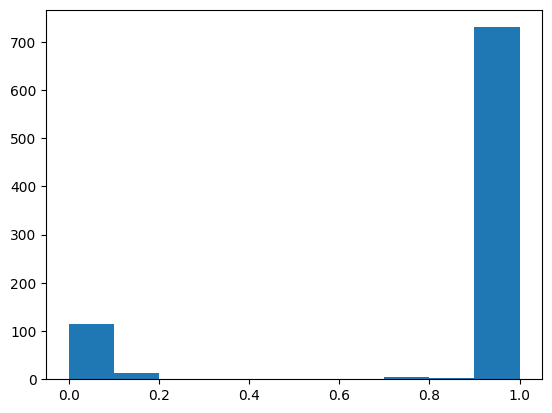

In [64]:
# Time to do the essentiality tests!!!
from tqdm import tqdm

with model:
    ex_glc.bounds = (-10, 0)
    sol = model.optimize()
    baseline = sol.objective_value

growth_rates = []
essentialities = []
for gene, index in tqdm(model_to_data_genes.items()):
    # Retrieve whether the gene is experimentally essential
    essential = df.loc[index]["Essential"]
    essentialities.append(essential)

    # Get model growth rate
    with model:
        ex_glc.bounds = (-10, 0)
        gene.knock_out()
        sol = model.optimize()
        growth_rates.append(sol.objective_value)
growth_rates = np.array(growth_rates)

fig, ax = plt.subplots()
ax.hist(growth_rates / baseline)

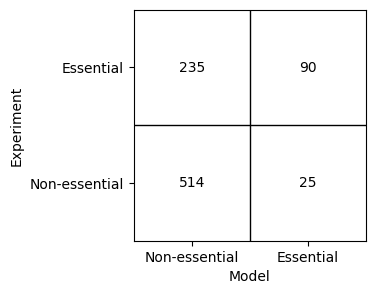

In [65]:
from collections import Counter

model_essential = (growth_rates < 1e-6)

fig, ax = plt.subplots()
for (model_x, data_y), count in Counter(zip(model_essential, essentialities)).items():
    ax.text(model_x/2 + 0.25,
            data_y/2 + 0.25,
            str(count),
            ha="center",
            va="center")

ax.vlines(0.5, 0, 1, "k", lw=1)
ax.hlines(0.5, 0, 1, "k", lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([.25, .75], ["Non-essential", "Essential"])
ax.set_yticks([.25, .75], ["Non-essential", "Essential"])
ax.set_xlabel("Model")
ax.set_ylabel("Experiment")

fig.set_size_inches(3, 3)

In [66]:
# Now, let's run a reaction essentiality test, so that we can relate the gene essentiality to the reaction essentiality
reaction_essentialities = []
for reaction in tqdm(model.reactions):
    with model:
        ex_glc.bounds = (-10, 0)
        reaction.knock_out()
        sol = model.optimize()
        reaction_essentialities.append(sol.objective_value)
reaction_essentialities = np.array(reaction_essentialities)
reaction_essentialities = reaction_essentialities < 1e-6
reaction_essentialities = dict(zip(model.reactions, reaction_essentialities))

100%|██████████| 1812/1812 [00:28<00:00, 63.09it/s]


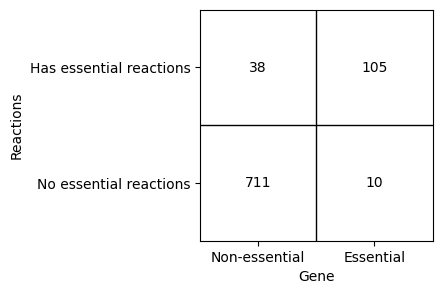

In [67]:
# Now we can relate the gene essentiality to the reaction essentiality
gene_reaction_categories = Counter()
strange = []
for gene, essentiality in zip(model_to_data_genes, model_essential):
    reactions = gene.reactions
    gene_reaction_essentialities = [reaction_essentialities[reaction] for reaction in reactions]
    has_essential_reactions = any(gene_reaction_essentialities)

    gene_reaction_categories[(essentiality, has_essential_reactions)] += 1

    if essentiality and not has_essential_reactions:
        strange.append(gene)

fig, ax = plt.subplots()
for (model_x, data_y), count in gene_reaction_categories.items():
    ax.text(model_x/2 + 0.25,
            data_y/2 + 0.25,
            str(count),
            ha="center",
            va="center")
ax.vlines(0.5, 0, 1, "k", lw=1)
ax.hlines(0.5, 0, 1, "k", lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([.25, .75], ["Non-essential", "Essential"])
ax.set_yticks([.25, .75], ["No essential reactions", "Has essential reactions"])
ax.set_xlabel("Gene")
ax.set_ylabel("Reactions")
fig.set_size_inches(3, 3)


In [68]:
for gene in strange:
    print(f"{gene.id}\n====================")
    for reaction in gene.reactions:
        print(f"\t{reaction.id} ({reaction_essentialities[reaction]})")

SPO0426
	NAD-SYNTH-GLN-RXN (False)
	NAD-SYNTH-NH3-RXN (False)
SPO1312
	RXN-14325 (False)
	CTPSYN-RXN (False)
	GLUTAMIN-RXN (False)
SPO0963
	RXN-13482 (False)
	ORNCARBAMTRANSFER-RXN (False)
SPO0210
	RXN-18204 (False)
	RXN-18206 (False)
	RXNQT-4168 (False)
	RXNQT-4171 (False)
	RXNQT-4174 (False)
	RXN-18200 (False)
	RXNQT-4178 (False)
	RXNQT-4165 (False)
	RXN-14986 (False)
	RXN-18210 (False)
	RXN-13158 (False)
	RXN-18208 (False)
	3-ISOPROPYLMALDEHYDROG-RXN (False)
	RXN-18202 (False)
SPO3207
	RXN0-884 (False)
	ISPH2-RXN (False)
SPO1734
	HOMOSERDEHYDROG-RXN-HOMO-SER/NAD//L-ASPARTATE-SEMIALDEHYDE/NADH/PROTON.51. (False)
	HOMOSERDEHYDROG-RXN-HOMO-SER/NADP//L-ASPARTATE-SEMIALDEHYDE/NADPH/PROTON.53. (False)
SPO1364
	5.4.2.10-RXN (False)
	5.4.2.10-RXN-CPD-13469//GLUCOSAMINE-1P.26. (False)
SPO2109
	GMP-SYN-NH3-RXN (False)
	GMP-SYN-GLUT-RXN (False)
	GLUTAMIN-RXN (False)
SPO3159
	PRPPSYN-RXN-CPD-16551/ATP//PRPP/AMP/PROTON.31. (False)
	PRPPSYN-RXN (False)
	PRPPSYN-RXN-CPD-15318/ATP//PRPP/AMP/PROTON.

In [29]:
# Check SPO_RS14555
gene = model.genes.get_by_id("SPO_RS14555")
with model:
    ex_glc.bounds = (-10, 0)
    gene.knock_out()
    sol = model.optimize()
    print(sol.objective_value)

KeyError: 'SPO_RS14555'